# Citi Bike Data Analysis
====================================

In [11]:
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pandas as pd

/Users/danielstallworth/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [14]:
%matplotlib inline

In [3]:
r = requests.get('http://www.citibikenyc.com/stations/json')

In [4]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [5]:
len(r.json()['stationBeanList'])

508

In [7]:
key_list = []
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)

In [8]:
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [10]:
df = json_normalize(r.json()['stationBeanList'])

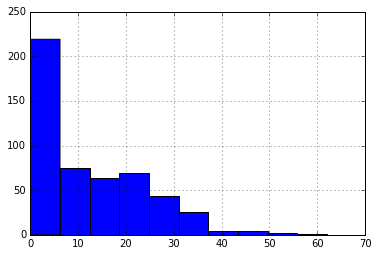

In [15]:
df['availableBikes'].hist()
plt.show()

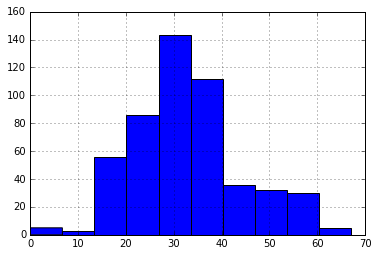

In [27]:
df['totalDocks'].hist()
plt.show()

In [17]:
df['availableBikes'].mean()

12.338582677165354

In [18]:
df['availableBikes'].median()

9.0

In [19]:
df.groupby('statusKey')['availableBikes'].mean()

statusKey
1    12.536
3     0.000
Name: availableBikes, dtype: float64

In [21]:
df.groupby('testStation')['availableBikes'].count()

testStation
False    508
Name: availableBikes, dtype: int64

In [23]:
df.groupby('statusValue')['availableBikes'].count()

statusValue
In Service        500
Not In Service      8
Name: availableBikes, dtype: int64

In [28]:
import sqlite3 as lite

In [64]:
con = lite.connect('citi_bike.db')
cur = con.cursor()

In [32]:
cur.execute('DROP TABLE citibike_reference')

In [33]:
with con:
    cur.execute('''CREATE TABLE citibike_reference (
                id INT PRIMARY KEY, 
                totalDocks INT,
                city TEXT,
                altitude INT, 
                stAddress2 TEXT, 
                longitude NUMERIC, 
                postalCode TEXT,
                testStation TEXT,
                stAddress1 TEXT,
                stationName TEXT, 
                landMark TEXT,
                latitude NUMERIC,
                location TEXT)''')

In [34]:
sql = '''INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode,
                                        testStation, stAddress1, stationName, landMark, latitude, location)
                                        VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)'''

In [35]:
with con:
    for s in r.json()['stationBeanList']:
        cur.execute(sql, (s['id'], s['totalDocks'], s['city'], s['altitude'], s['stAddress2'], s['longitude'], s['postalCode'],
                    s['testStation'], s['stAddress1'], s['stationName'], s['landMark'], s['latitude'], s['location']))

In [69]:
with con:
    cr = cur.execute('select * from citibike_reference limit 10')

In [70]:
cr

In [55]:
cur.execute('DROP TABLE available_bikes')

In [48]:
station_ids = ['_' + str(x) + ' INT' for x in df['id'].tolist()]

In [57]:
with con:
    cur.execute('CREATE TABLE available_bikes (execution_time INT, ' + ','.join(station_ids) + ');')

In [59]:
print('CREATE TABLE available_bikes (execution_time INT, ' + ','.join(station_ids) + ');')

CREATE TABLE available_bikes (execution_time INT, _72 INT,_79 INT,_82 INT,_83 INT,_116 INT,_119 INT,_120 INT,_127 INT,_128 INT,_137 INT,_143 INT,_144 INT,_146 INT,_147 INT,_150 INT,_151 INT,_152 INT,_153 INT,_157 INT,_161 INT,_164 INT,_167 INT,_168 INT,_173 INT,_174 INT,_195 INT,_212 INT,_216 INT,_217 INT,_223 INT,_224 INT,_225 INT,_228 INT,_229 INT,_232 INT,_236 INT,_237 INT,_238 INT,_239 INT,_241 INT,_242 INT,_243 INT,_244 INT,_245 INT,_247 INT,_248 INT,_249 INT,_250 INT,_251 INT,_252 INT,_253 INT,_254 INT,_257 INT,_258 INT,_259 INT,_260 INT,_261 INT,_262 INT,_263 INT,_264 INT,_265 INT,_266 INT,_267 INT,_268 INT,_270 INT,_274 INT,_275 INT,_276 INT,_278 INT,_279 INT,_280 INT,_281 INT,_282 INT,_284 INT,_285 INT,_289 INT,_291 INT,_293 INT,_295 INT,_296 INT,_297 INT,_298 INT,_300 INT,_301 INT,_302 INT,_303 INT,_304 INT,_305 INT,_306 INT,_307 INT,_308 INT,_309 INT,_310 INT,_311 INT,_312 INT,_313 INT,_315 INT,_316 INT,_317 INT,_319 INT,_320 INT,_321 INT,_322 INT,_323 INT,_324 INT,_325 INT,

In [39]:
import time

In [40]:
from dateutil.parser import parse
import collections

In [50]:
exec_time = parse(r.json()['executionTime'])

In [63]:
r.json()['executionTime']

u'2016-06-25 04:41:11 AM'

In [51]:
with con:
    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)',(exec_time.strftime('%s'),))

In [62]:
exec_time

'1466847671'

In [52]:
id_bikes = collections.defaultdict(int)

In [53]:
for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']

In [54]:
with con:
    for k,v in id_bikes.iteritems():
        cur.execute('UPDATE available_bikes SET _' + str(k) + ' = ' + str(v) + ' WHERE execution_time = ' + 
                    exec_time.strftime('%s') + ';')

In [58]:
for i in range(60): # Inserts data into the DB every minute for an hour
    r = requests.get('http://www.citibikenyc.com/stations/json')
    exec_time = parse(r.json()['executionTime']).strftime("%s")

    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time,))

    for station in r.json()['stationBeanList']:
        cur.execute("UPDATE available_bikes SET _%d = %d WHERE execution_time = %s" % (station['id'], station['availableBikes'], exec_time))
    con.commit()

    time.sleep(60)

con.close() #close the database connection when done